# GCN Deep Graph Infomax on CORA

This demo demonstrates how to perform unsupervised training of a GCN, GAT, APPNP, or GraphSAGE model using the Deep Graph Infomax algorithm (https://arxiv.org/pdf/1809.10341.pdf) on the CORA dataset. 

As with all StellarGraph workflows: first we load the dataset, next we create our data generators, and then we train our model. We then take the embeddings created through unsupervised training and predict the node classes using logistic regression.

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/deep-graph-infomax-cora.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/deep-graph-infomax-cora.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]

In [2]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

In [3]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

 ## Data Generators
 
 Now we create the data generators using `CorruptedGenerator`. `CorruptedGenerator` returns shuffled node features along with the regular node features and we train our model to discriminate between the two. 
 
 Note that:
 
 - We typically pass all nodes to `generator.flow` because this is an unsupervised task
 - We don't pass `targets` to `generator.flow` because these are binary labels (true nodes, false nodes) that are created by `CorruptedGenerator`

In [4]:
# model type can be: GraphSAGE, GAT, GCN, or APPNP
model_type = GraphSAGE

In [5]:
if model_type in [GAT, GCN, APPNP]:
    generator = FullBatchNodeGenerator(G, sparse=False)
elif model_type is GraphSAGE:
    generator = GraphSAGENodeGenerator(G, batch_size=2700, num_samples=[5])
else:
    raise NotImplementedError(
        f"model_type: expected `GraphSAGE`, `GCN`, `GAT`,"
        f" or `APPNP`, found '{model_type}'."
    )

base_model = model_type(layer_sizes=[512], activations=["relu"], generator=generator)

corrupted_generator = CorruptedGenerator(generator)
gen = corrupted_generator.flow(G.nodes())

## Model Creation and Training

We create and train our `DeepGraphInfomax` model. Note that the loss used here must always be `tf.nn.sigmoid_cross_entropy_with_logits`.

In [6]:
infomax = DeepGraphInfomax(base_model)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [7]:
model = Model(inputs=model.input, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

  ['...']


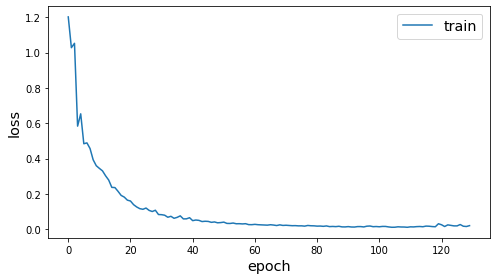

In [8]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=200, verbose=0, callbacks=[es])
plot_history(history)

## Extracting Embeddings and Logistic Regression

We create an embedding model using `DeepGraphInfomax.embedding_model` to obtain the node embeddings. Then we use logistic regression to predict which class the node belongs to.

Note that the results here differ from the paper due to different train/test/val splits.

In [9]:
x_emb_in, x_emb_out = infomax.embedding_model()
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

In [10]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

test_gen = generator.flow(test_subjects.index)
train_gen = generator.flow(train_subjects.index)

test_embeddings = emb_model.predict(test_gen)
train_embeddings = emb_model.predict(train_gen)

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

y_pred = lr.predict(test_embeddings)
print("Test classification accuracy:", (y_pred == test_subjects).mean())

Test classification accuracy: 0.7309269893355209


## Visualisation with TSNE

Here we visualize the node embeddings with TSNE. As you can see below, the Deep Graph Infomax model produces well separated embeddings using unsupervised training.

In [11]:
all_embeddings = emb_model.predict(generator.flow(G.nodes()))

y = node_subjects.astype("category")
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())
emb_transformed["label"] = y

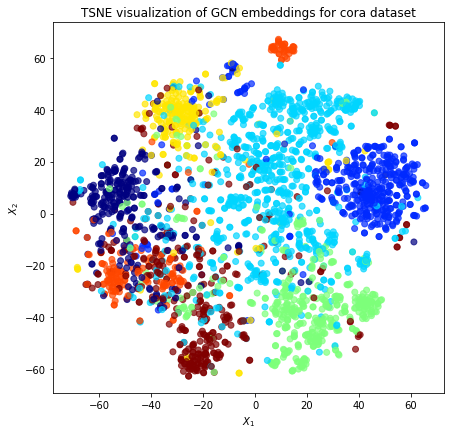

In [12]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE visualization of GCN embeddings for cora dataset")
plt.show()

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/deep-graph-infomax-cora.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/deep-graph-infomax-cora.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>